In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
data = pd.read_excel('empregado.xlsx')

# Preparação e tratamento dos dados

In [105]:
# excluindo linhas com variáveis ausentes
data2 = data.dropna(axis=0, how='any')
data2.groupby('performance')['id_empregado'].count()

performance
Abaixo da média       1568
Entre os melhores    27487
Name: id_empregado, dtype: int64

In [106]:
# Realizando Análise de Componentes Principais para reduzir variáveis e criar uma variável chamada clima organizacional.

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
clima= data2[['clim1', 'clim2','clim3','clim4','clim5','clim6','clim7','clim8','clim9','clim10','clim11','clim12','clim13','clim14','clim15','clim16','clim17','clim17','clim19','clim20','clim21','clim22','clim23','clim24','clim25','clim26','clim27','clim28','clim29','clim30','clim31','clim32','clim33','clim34','clim35','clim36','clim37','clim38','clim39','clim40','clim41','clim42','clim43','clim44','clim45','clim46','clim47','clim48','clim49','clim50','clim51','clim52','clim53','clim54','clim55','clim56']]
scaler = StandardScaler()
scaler.fit(clima)
scaled_data = scaler.transform(clima)
pca = PCA(n_components=1)
pca.fit(scaled_data)
clima_pca = pca.transform(scaled_data)
clima_pca
clima= pd.DataFrame(clima_pca, columns= ['clima'])


In [107]:
#Tratando a variável idade
idade= data2['idade']
def fxidade(idade):
     if idade >= 60:
        return'60 anos ou mais'
     elif idade >= 40:
        return 'entre 40 e 59 anos'
     elif idade >= 30:
        return 'entre 30 e 39 anos'
     else:
        return 'entre 18 e 29 anos'
fxidade= list(map(fxidade,idade))
fxidade= pd.DataFrame(fxidade,columns= ['fxidade'])

In [108]:
#Concatenando as variáveis tratadas e reduzidas à segunda versão do banco de dados

data2=pd.concat([data2.reset_index(), fxidade.reset_index(), clima.reset_index()], axis=1)

In [109]:
# Identificando variáveis previsoras e a classe que será prevista

previsores= data2[['faixaempregado','setor','fxidade','excelentelugar','cargo','localtrabalho','tempoempresa','salariobruto', 'instrucao', 'deficiencia', 'raça', 'sexo', 'estado', 'fatorretencao', 'ambetico', 'avalprincexec', 'lideranca','retencao', 'clima']]
classe= data2[['performance']]

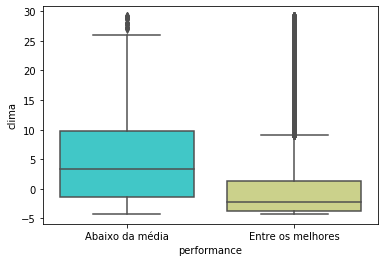

In [110]:
#Identificando a distribuição e os outliers da variável clima organizacional

import seaborn as sns
%matplotlib inline
sns.boxplot(x="performance", y="clima", data=data2,palette='rainbow')

In [111]:
def show_distribution(var_data):
    from matplotlib import pyplot as plt

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))
# Get the variable to examine
col = data2['clima']
# Call the function
show_distribution(col)

Minimum:-4.23
Mean:0.00
Median:-2.00
Mode:-4.23
Maximum:29.16



In [112]:
#Retirando os outliers da variável clima organizacional a partir do percentil 85.

q85 = data2.clima.quantile(0.85)
# Get the variable to examine
col = data2[data2.clima<q85]['clima']
# Call the function
show_distribution(col)

Minimum:-4.23
Mean:-1.82
Median:-2.65
Mode:-4.23
Maximum:4.58



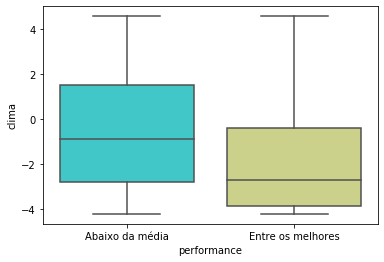

In [113]:
# distribuição da variável clima organizacional sem outliers
data2['clima']= col
data2 = data2.dropna(axis=0, how='any')
sns.boxplot(x="performance", y="clima", data=data2,palette='rainbow')

In [122]:
# Transformando a variável preditora em binária (dummies)

previsores= pd.get_dummies(previsores)

# Transformando a variável classe em binária

from sklearn.preprocessing import LabelEncoder
labelencoder_classe = LabelEncoder()
classe= labelencoder_classe.fit_transform(classe)
classe=pd.DataFrame(classe)

# Balanceamento da quantidade de registros das variáveis preditoras e classe

from imblearn.over_sampling import SMOTE
smt = SMOTE()
previsores, classe= smt.fit_sample(previsores, classe)

#Dividindo as amostras de treino e teste

from sklearn.model_selection import train_test_split
previsores_train, previsores_test, classe_train, classe_test = train_test_split(previsores, classe, test_size=0.30, 
                                                    random_state=101)
print ('Training cases: %d\nTest cases: %d' % (previsores_train.shape[0], previsores_test.shape[0]))


C:\Users\silva\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training cases: 38481
Test cases: 16493


# Treinamento do modelo - Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5)
rf.fit(previsores_train, classe_train)

C:\Users\silva\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(n_estimators=5)

Confusion Matrix:
 [[7847  369]
 [ 310 7967]] 

Accuracy: 0.9588310192202752
Overall Precision: 0.9557341650671785
Overall Recall: 0.9625468164794008
AUC: 0.9867448793179773


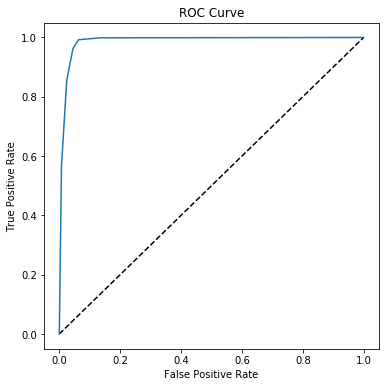

In [125]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Obtendo previsões a partir da amostra de teste
predictions = rf.predict(previsores_test)
classe_scores = rf.predict_proba(previsores_test)

# Obtendo os indicadores de performance do modelo

cm = confusion_matrix(classe_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(classe_test, predictions))
print("Overall Precision:",precision_score(classe_test, predictions))
print("Overall Recall:",recall_score(classe_test, predictions))
auc = roc_auc_score(classe_test,classe_scores[:,1])
print('AUC: ' + str(auc))

# Cálculo e plot da curva ROC

fpr, tpr, thresholds = roc_curve(classe_test, classe_scores[:,1])
fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [91]:
rf.feature_importances_

# Criando um dataframe com as colunas e seus scores de importâncias:

previsores_importances = pd.DataFrame(rf.feature_importances_,
                                   index = previsores.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Idenfiticação das 10 principais variáveis preditoras 
previsores_importances.head(10)

,importance
lideranca_Inspirador,0.064028
clima,0.060843
"fatorretencao_Oportunidades de Desenvolvimento - Valorização da carreira e das oportunidades de aprendizagem, crescimento e desenvolvimento observadas na empresa",0.036329
localtrabalho_Fábrica / Produção / Agrícola / Obra / Laboratório,0.031704
retencao_Gostaria de me aposentar nesta empresa,0.030506
lideranca_Democrático,0.026721
lideranca_Pessoas em primeiro lugar,0.025707
avalprincexec_Excelente,0.024650
"excelentelugar_Ser reconhecido pela minha dedicação, por minhas novas ideias e perceber que meu esforço contribui para o sucesso da empresa",0.023208
"fatorretencao_Satisfação com o Trabalho - Sentimento de realização profissional, sentir-se satisfeito com o trabalho que realiza",0.021506


# Interpretação dos resultados por empregado

In [94]:
#Respostas de um empregado aleatório ao questionário

respostas= previsores_test.iloc[1]
respostas.sort_values(ascending= False).head(17)

cargo_Demais empregados                                                                                          1.0
deficiencia_Não                                                                                                  1.0
fxidade_entre 40 e 59 anos                                                                                       1.0
avalprincexec_Excelente                                                                                          1.0
tempoempresa_Até 06 meses de casa                                                                                1.0
setor_Moveleiro                                                                                                  1.0
raça_Branco                                                                                                      1.0
localtrabalho_Fábrica / Produção / Agrícola / Obra / Laboratório                                                 1.0
instrucao_ensino médio                                          

In [102]:
# Importâncias por varíavel preditora para um empregado aleatório da amostra de teste 

from treeinterpreter import treeinterpreter as ti, utils

selected_rows = [1]
selected_df = previsores_test.iloc[selected_rows,:].values
prediction, bias, contributions = ti.predict(rf, selected_df)

print('previsão', prediction)
for c, feature in zip(contributions[0][0:158,1:], previsores.columns):
    print (feature, c)

previsão [[0. 1.]]
ambetico [0.]
clima [0.11283884]
faixaempregado_Acima de 10 mil empregados [0.]
faixaempregado_Mais de 1 mil empregados [0.]
faixaempregado_Menos de 1 mil empregados [0.]
setor_Agronegócio [-0.00498694]
setor_Alimentos, bebidas e fumo [-0.00846163]
setor_Atacadista [0.]
setor_Automotivo [-0.00338655]
setor_Bancário [0.]
setor_Comércio Varejista [0.]
setor_Consultoria e Auditoria [0.]
setor_Cooperativa [-0.0007767]
setor_Educação [0.]
setor_Eletroeletrônico [0.]
setor_Empresa de Benefícios [0.]
setor_Energia [0.]
setor_Engenharia e Construção [-0.00183451]
setor_Farmacêutica [0.]
setor_Higiene e Cosméticos [0.00091671]
setor_Hospital [0.]
setor_Indústrias Diversas [-0.00553086]
setor_Indústrias de Embalagens [0.]
setor_Materiais de Construção [0.]
setor_Mineração, Metalurgia e Siderurgia [0.]
setor_Moveleiro [0.]
setor_Papel e Celulose [0.]
setor_Química e Petroquímica [-0.00080729]
setor_Saúde e Nutrição Animal [0.]
setor_Serviços Automotivos [0.]
setor_Serviços Dive

In [103]:
# classe real do empregado 1

classe= classe_test.iloc[1]
classe

0    1
Name: 9860, dtype: int64